<a href="https://colab.research.google.com/github/Aya-Ai-2022/Bike-Sharing-Kaggle/blob/main/Final_Bike.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Import Libraries**

In [ ]:
!pip install catboost

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 76.6/76.6 MB 12.7 MB/s eta 0:00:00


In [ ]:
import numpy as np
import pandas as pd
import math
from datetime import datetime
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import f_oneway
from sklearn.neighbors import  KNeighborsRegressor
from catboost import CatBoostRegressor 
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_log_error
from sklearn.svm import SVR
from sklearn.ensemble import RandomForestRegressor 
import lightgbm as lgb
from sklearn.tree import DecisionTreeRegressor
from sklearn.linear_model import Ridge
%matplotlib inline
sns.set_style("darkgrid")
import warnings
warnings.filterwarnings("ignore")

# **Data Inspection and Preprocessing**

In [ ]:
data= pd.read_csv('train.csv')

FileNotFoundError: ignored

In [ ]:
test=pd.read_csv('test.csv')

FileNotFoundError: ignored

In [ ]:
data.info()

In [ ]:
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6493 entries, 0 to 6492
Data columns (total 9 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   datetime    6493 non-null   object 
 1   season      6493 non-null   int64  
 2   holiday     6493 non-null   int64  
 3   workingday  6493 non-null   int64  
 4   weather     6493 non-null   int64  
 5   temp        6493 non-null   float64
 6   atemp       6493 non-null   float64
 7   humidity    6493 non-null   int64  
 8   windspeed   6493 non-null   float64
dtypes: float64(3), int64(5), object(1)
memory usage: 456.7+ KB


### Extract Hours and months from datetime from train and test data

In [ ]:
hour_train=[]
month_train=[]
for i in data['datetime']:
      date_data = datetime.strptime(i, "%Y-%m-%d %H:%M:%S")
      hour_train.append(date_data.hour)
      month_train.append(date_data.month)
data['hour'] = pd.DataFrame(hour_train)
data['hour'] = data['hour'].astype(float)
data['month'] = pd.DataFrame(month_train)
data['month'] = data['month'].astype(float)

In [ ]:
hour_test=[]
month_test=[]
for i in test['datetime']:
      date_test = datetime.strptime(i, "%Y-%m-%d %H:%M:%S")
      hour_test.append(date_test.hour)
      month_test.append(date_test.month)
test['hour'] = pd.DataFrame(hour_test)
test['hour'] = test['hour'].astype(float)
test['month'] = pd.DataFrame(month_test)
test['month'] = test['month'].astype(float)

### Hours VS Average Bikes Rent

In [ ]:
data.columns

Index(['datetime', 'season', 'holiday', 'workingday', 'weather', 'temp',
       'atemp', 'humidity', 'windspeed', 'casual', 'registered', 'count',
       'hour', 'month'],
      dtype='object')

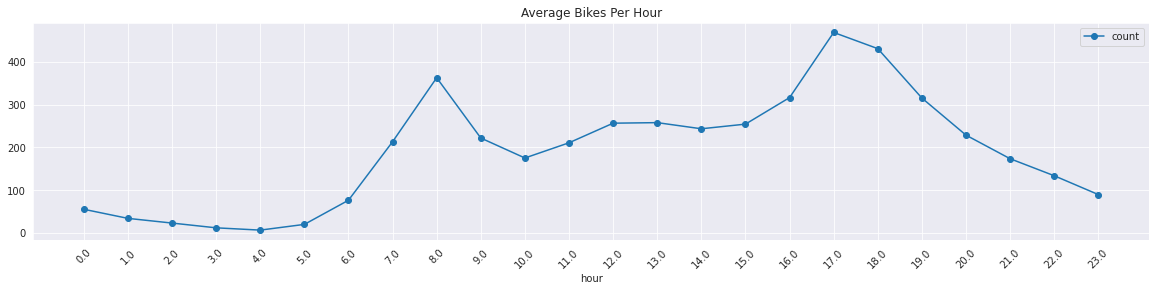

In [ ]:

avg_hrs = data.groupby('hour')['count'].mean()
plt.figure(figsize=(20,4))
fig=avg_hrs.plot(legend=True,marker='o',title="Average Bikes Per Hour")
fig.set_xticks(range(len(avg_hrs)));
fig.set_xticklabels(avg_hrs.index.tolist(), rotation=45);

In [ ]:
data1=data.drop(columns=['datetime'],axis=1)

In [ ]:
test1=test.drop(columns=['datetime'],axis=1)

In [ ]:
data1.head(5)

,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,count,hour,month
0,1,0,0,1,9.84,14.395,81,0.0,3,13,16,0.0,1.0
1,1,0,0,1,9.02,13.635,80,0.0,8,32,40,1.0,1.0
2,1,0,0,1,9.02,13.635,80,0.0,5,27,32,2.0,1.0
3,1,0,0,1,9.84,14.395,75,0.0,3,10,13,3.0,1.0
4,1,0,0,1,9.84,14.395,75,0.0,0,1,1,4.0,1.0


In [ ]:
data2=data1.copy()

# **EDA**

### Description from Kaggle

#### **season**  
* 1 = spring
* 2 = summer
* 3 = fall
* 4 = winter 

**holiday** 
* whether the day is considered a holiday

**workingday**
 * whether the day is neither a weekend nor holiday

**weather**
* 1: Clear, Few clouds, Partly cloudy, Partly cloudy
* 2: Mist + Cloudy, Mist + Broken clouds, Mist + Few clouds, Mist
* 3: Light Snow, Light Rain + Thunderstorm + Scattered clouds, Light Rain + Scattered clouds
* 4: Heavy Rain + Ice Pallets + Thunderstorm + Mist, Snow + Fog 

In [ ]:
data2.season=data2.season.astype(str)

In [ ]:
test1.season=test1.season.astype(str)

In [ ]:
season_description={"1": "Spring", "2": "Summer","3": "Fall","4":"Winter_Holiday"}

In [ ]:
data2.replace({"season": season_description},inplace = True)

In [ ]:
test1.replace({"season": season_description},inplace = True)

In [ ]:
data2.tail(7)

,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,count,hour,month
10879,Winter_Holiday,0,1,1,16.40,20.455,50,26.0027,26,536,562,17.0,12.0
10880,Winter_Holiday,0,1,1,15.58,19.695,50,23.9994,23,546,569,18.0,12.0
10881,Winter_Holiday,0,1,1,15.58,19.695,50,26.0027,7,329,336,19.0,12.0
10882,Winter_Holiday,0,1,1,14.76,17.425,57,15.0013,10,231,241,20.0,12.0
10883,Winter_Holiday,0,1,1,13.94,15.910,61,15.0013,4,164,168,21.0,12.0
10884,Winter_Holiday,0,1,1,13.94,17.425,61,6.0032,12,117,129,22.0,12.0
10885,Winter_Holiday,0,1,1,13.12,16.665,66,8.9981,4,84,88,23.0,12.0


In [ ]:
data2.month=data2.month.astype(str)

In [ ]:
test1.month=test1.month.astype(str)

In [ ]:
month_description={"1.0": "Jan", "2.0": "Feb","3.0": "Mar","4.0":"Apr","5.0": "May", "6.0": "Jun","7.0": "Jul","8.0":"Aug","9.0": "Sept", "10.0": "Oct","11.0": "Nov","12.0":"Dec"}

In [ ]:
data2.replace({"month": month_description},inplace = True)

In [ ]:
test1.replace({"month": month_description},inplace = True)

In [ ]:
data2.weather=data2.weather.astype(str)

In [ ]:
test1.weather=test1.weather.astype(str)

In [ ]:
Weather_description={"1": "Clear", "2": "Misty_Cloudy","3": "Light_Snow","4":"Heavy_Rain"}

In [ ]:
data2.replace({"weather": Weather_description},inplace = True)

In [ ]:
test1.replace({"weather": Weather_description},inplace = True)

In [ ]:
data2.weather=data2.weather.astype('category')

In [ ]:
test1.weather=test1.weather.astype('category')

In [ ]:
data2.holiday=data2.holiday.astype('category')

In [ ]:
test1.holiday=test1.holiday.astype('category')

In [ ]:
data2.month=data2.month.astype('category')

In [ ]:
test1.month=test1.month.astype('category')

In [ ]:
data2.workingday=data2.workingday.astype('category')

In [ ]:
test1.workingday=test1.workingday.astype('category')

In [ ]:
data2.season=data2.season.astype('category')

In [ ]:
test1.season=test1.season.astype('category')

In [ ]:
data2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10886 entries, 0 to 10885
Data columns (total 13 columns):
 #   Column      Non-Null Count  Dtype   
---  ------      --------------  -----   
 0   season      10886 non-null  category
 1   holiday     10886 non-null  category
 2   workingday  10886 non-null  category
 3   weather     10886 non-null  category
 4   temp        10886 non-null  float64 
 5   atemp       10886 non-null  float64 
 6   humidity    10886 non-null  int64   
 7   windspeed   10886 non-null  float64 
 8   casual      10886 non-null  int64   
 9   registered  10886 non-null  int64   
 10  count       10886 non-null  int64   
 11  hour        10886 non-null  float64 
 12  month       10886 non-null  category
dtypes: category(5), float64(4), int64(4)
memory usage: 734.7 KB


### Categorical Features

In [ ]:
categorical_features= data2.select_dtypes(include='category')

In [ ]:
categorical_features.columns.to_list()

['season', 'holiday', 'workingday', 'weather', 'month']

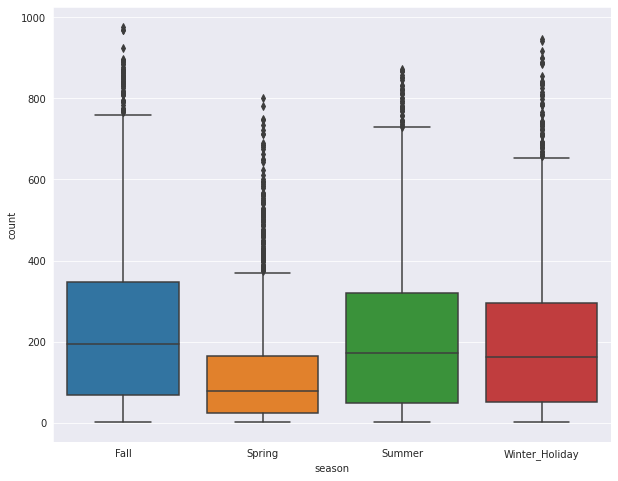

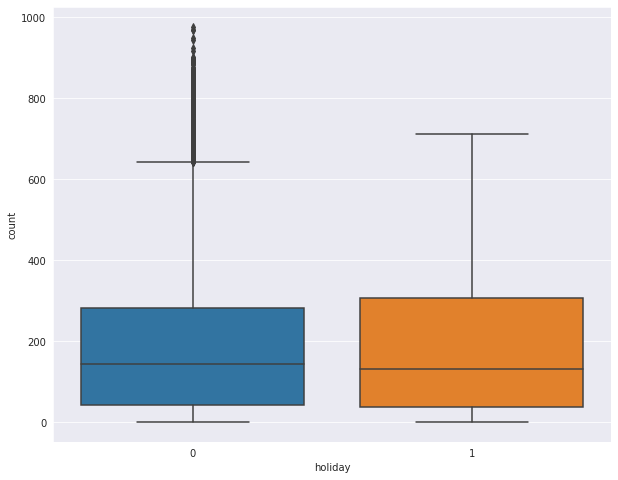

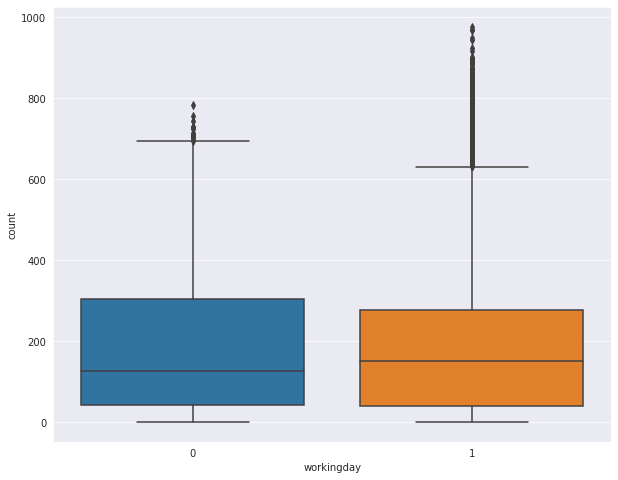

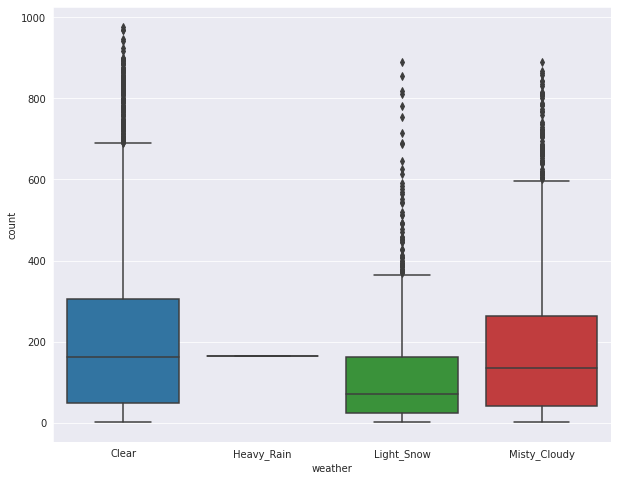

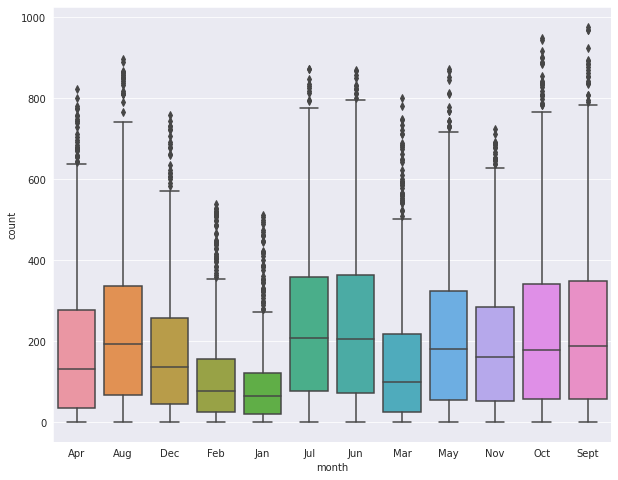

In [ ]:
for col in categorical_features:
  plt.figure(figsize=(10,8))
  sns.boxplot(x=data2[col],y=data2["count"])
  plt.show()

<Figure size 720x576 with 0 Axes>

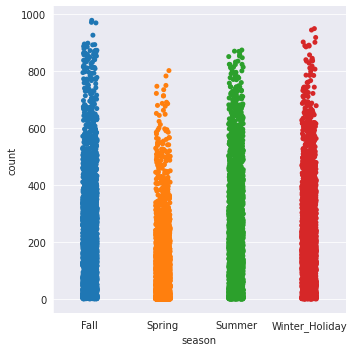

<Figure size 720x576 with 0 Axes>

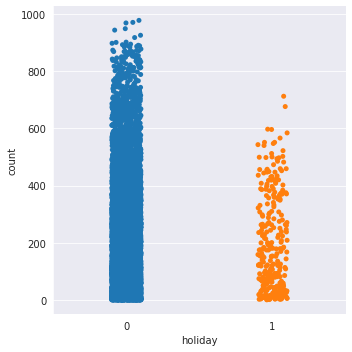

<Figure size 720x576 with 0 Axes>

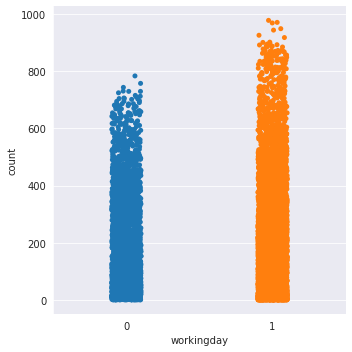

<Figure size 720x576 with 0 Axes>

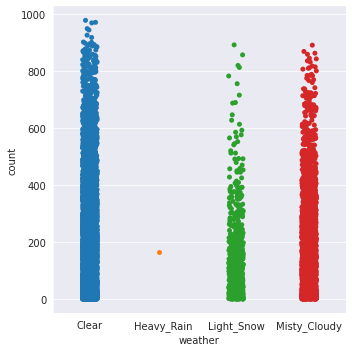

<Figure size 720x576 with 0 Axes>

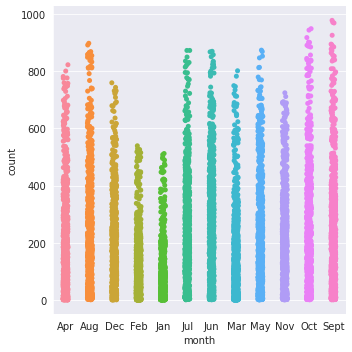

In [ ]:
for col in categorical_features:
  plt.figure(figsize=(10,8))
  sns.catplot(x=col,y='count',data=data2)
  plt.show()

In [ ]:
data2['count']=data1['count']

### f_oneway() function takes the group data as input and

In [ ]:
Category_GroupLists=categorical_features.columns.to_list()

#### Assumption(H0) is that each category and number of bikes rented are NOT correlated

In [ ]:
for category in Category_GroupLists:
    CategoryGroupLists=data2.groupby(category)['count'].apply(list)
    AnovaResults = f_oneway(*CategoryGroupLists)
    print(f'P-Value for Anova for  {category} is: { AnovaResults[1]}')

P-Value for Anova for  season is: 6.164843386499654e-149
P-Value for Anova for  holiday is: 0.5736923883252254
P-Value for Anova for  workingday is: 0.22644804226428558
P-Value for Anova for  weather is: 5.482069475935669e-42
P-Value for Anova for  month is: 3.9670124592000667e-171


In [ ]:
data2.columns

Index(['season', 'holiday', 'workingday', 'weather', 'temp', 'atemp',
       'humidity', 'windspeed', 'casual', 'registered', 'count', 'hour',
       'month'],
      dtype='object')

<AxesSubplot:>

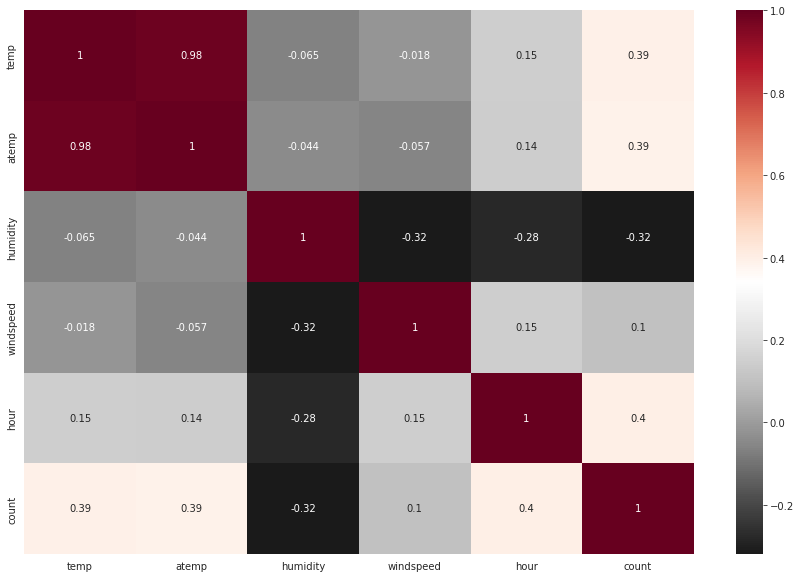

In [ ]:
plt.figure(figsize=(15,10))
sns.heatmap(data2[['temp', 'atemp','humidity', 'windspeed', 'hour','count']].corr(),cmap='RdGy_r',annot=True)

In [ ]:
continous_features=data2[[ 'temp', 'atemp',
       'humidity', 'windspeed',  'count', 'hour']]

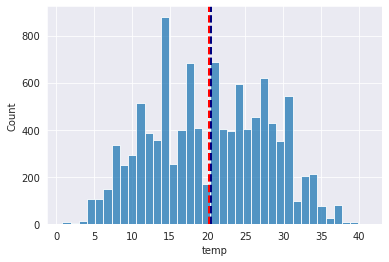

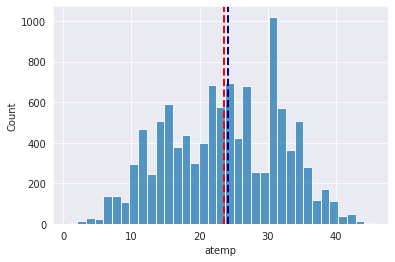

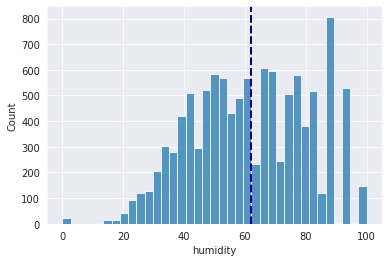

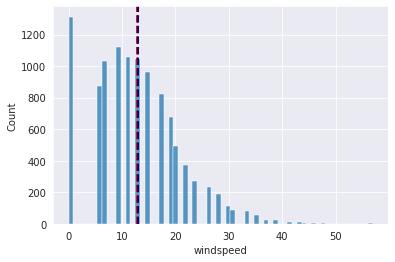

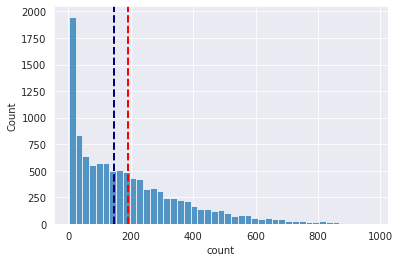

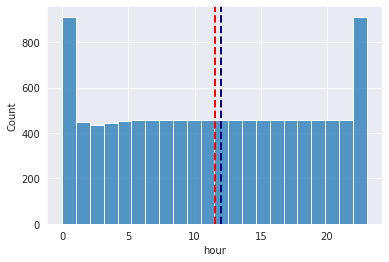

In [ ]:
for col in continous_features[:]:
  sns.histplot(data2[col])
  plt.axvline(data2[col].mean(), color='red', linestyle='dashed', linewidth=2)
  plt.axvline(data2[col].median(), color='navy', linestyle='dashed', linewidth=2)   
  plt.show()

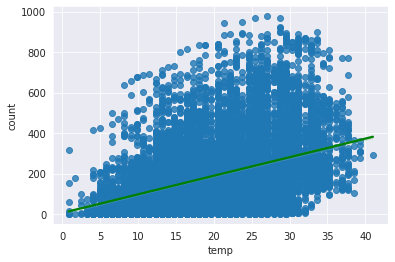

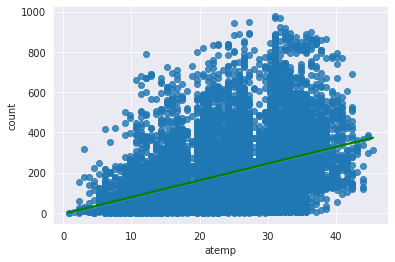

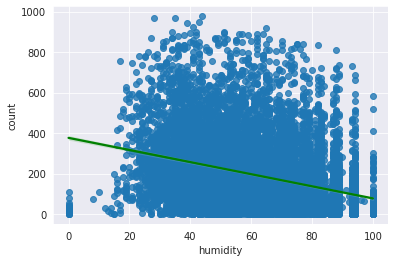

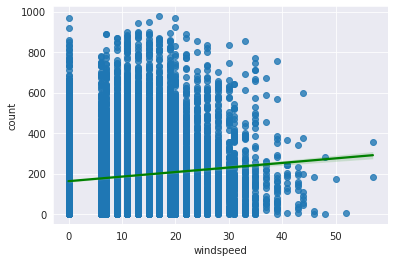

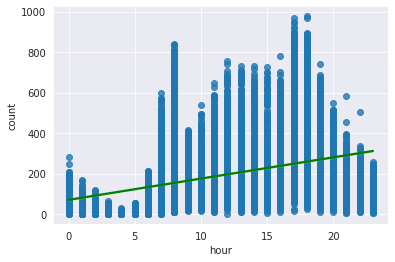

In [ ]:
for col in continous_features[:]:
  if col == 'count':
    pass
  else:
    sns.regplot(x=data2[col],y=data2["count"],line_kws={"color": "green"})
  
  plt.show()

In [ ]:
data2.columns

Index(['season', 'holiday', 'workingday', 'weather', 'temp', 'atemp',
       'humidity', 'windspeed', 'casual', 'registered', 'count', 'hour',
       'month'],
      dtype='object')

# **Models**

In [ ]:
y= data2['count']

In [ ]:
data2.columns

Index(['season', 'holiday', 'workingday', 'weather', 'temp', 'atemp',
       'humidity', 'windspeed', 'casual', 'registered', 'count', 'hour',
       'month'],
      dtype='object')

In [ ]:
X=data2.drop(columns=['registered','casual','count','holiday', 'workingday'],axis=1)

In [ ]:
dummy_categorical_feature= pd.get_dummies(categorical_features[['season','holiday', 'workingday', 'weather','month']],drop_first=True)

In [ ]:
dummy_categorical_test_feature= pd.get_dummies(test1[['season', 'holiday', 'workingday', 'weather', 'month']],drop_first=True)

In [ ]:
continous_test_features=test1[['temp', 'atemp', 'humidity', 'windspeed', 'hour']]

In [ ]:
final_df_features= pd.concat([dummy_categorical_feature,continous_features.drop(columns=['count'],axis=1)],axis=1)

In [ ]:
final_df= pd.concat([dummy_categorical_feature,continous_features.drop(columns=['count'],axis=1)],axis=1)

In [ ]:
final_df_test= pd.concat([dummy_categorical_test_feature,continous_test_features],axis=1)

In [ ]:
scaler=StandardScaler()

In [ ]:
final_df=scaler.fit_transform(final_df)


In [ ]:
final_df_test=scaler.transform(final_df_test)

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(final_df, y, test_size=0.25, random_state=42)

In [ ]:
mean_squared_log_errors={}
R_Squared={}

In [ ]:
def run_model(model,X_train,y_train,X_test,y_test):
    model.fit(X_train,y_train)
    preds = model.predict(X_test)
    R=r2_score(y_test,preds)
    preds=abs(preds)
    MSLE=mean_squared_log_error(preds,y_test)
    return (R,MSLE)

In [ ]:
knn = KNeighborsRegressor(n_jobs=-1)
R=run_model(knn,X_train,y_train,X_test,y_test)[0]
msle=run_model(knn,X_train,y_train,X_test,y_test)[1]
print(f"R^2 Score: {R}")
print(f"MSLE Score: {msle}")
mean_squared_log_errors["KNeighborsRegressor"]=msle
R_Squared["KNeighborsRegressor"]=R


R^2 Score: 0.6159365003389863
MSLE Score: 0.7824337670227854


In [ ]:
ridge = Ridge()
R=run_model(ridge,X_train,y_train,X_test,y_test)[0]
msle=run_model(ridge,X_train,y_train,X_test,y_test)[1]
print(f"R^2 Score: {R}")
print(f"MSLE Score: {msle}")
mean_squared_log_errors["Ridge Regression"]=msle
R_Squared["Ridge Regression"]=R

R^2 Score: 0.35013488849302055
MSLE Score: 1.4362539881403984


In [ ]:
regressor_DT = DecisionTreeRegressor()
R=run_model(regressor_DT,X_train,y_train,X_test,y_test)[0]
msle=run_model(regressor_DT,X_train,y_train,X_test,y_test)[1]
print(f"R^2 Score: {R}")
print(f"MSLE Score: {msle}")
mean_squared_log_errors["Decision Tree"]=msle
R_Squared["Decision Tree"]=R

R^2 Score: 0.7472369713371922
MSLE Score: 0.2949552966502702


In [ ]:
cb_model=CatBoostRegressor(verbose=0)
R=run_model(cb_model,X_train,y_train,X_test,y_test)[0]
msle=run_model(cb_model,X_train,y_train,X_test,y_test)[1]
print(f"R^2 Score: {R}")
print(f"MSLE Score: {msle}")
mean_squared_log_errors["CatBoostRegressor"]=msle
R_Squared["CatBoostRegressor"]=R

R^2 Score: 0.8781949965049658
MSLE Score: 0.2604853838769146


In [ ]:
lgbr=lgb.LGBMRegressor()
R=run_model(lgbr,X_train,y_train,X_test,y_test)[0]
msle=run_model(lgbr,X_train,y_train,X_test,y_test)[1]
print(f"R^2 Score: {R}")
print(f"MSLE Score: {msle}")
mean_squared_log_errors["LGBMRegressor"]=msle
R_Squared["LGBMRegressor"]=R

R^2 Score: 0.8721362780695147
MSLE Score: 0.23252211015243118


In [ ]:
regressor_RF = RandomForestRegressor()
R=run_model(regressor_RF,X_train,y_train,X_test,y_test)[0]
msle=run_model(regressor_RF,X_train,y_train,X_test,y_test)[1]
print(f"R^2 Score: {R}")
print(f"MSLE Score: {msle}")
mean_squared_log_errors["Random Forest"]=msle
R_Squared["Random Forest"]=R

R^2 Score: 0.8604830947057687
MSLE Score: 0.17775281509038687


## **Final Kaggle Submission with best results**

In [ ]:
kk=regressor_RF.predict(final_df_test)
ans1=pd.DataFrame()
ans1['datetime']=test['datetime']
ans1['count']=kk
ans1.to_csv('RF_all_Feat.csv',index=False)

In [ ]:
mean_squared_log_errors_results = pd.DataFrame.from_dict(mean_squared_log_errors,orient = "index",columns=["Mean Squared Log Score"])
#mean_squared_log_errors_results

In [ ]:
R_Squared_results = pd.DataFrame.from_dict(R_Squared,orient = "index",columns=["R Squared"])
#R_Squared_results

In [ ]:
R_Squared_results["Mean Squared Log Score"]=mean_squared_log_errors_results["Mean Squared Log Score"]

In [ ]:
R_Squared_results

,R Squared,Mean Squared Log Score
KNeighborsRegressor,0.615937,0.782434
Ridge Regression,0.350135,1.436254
Decision Tree,0.747237,0.294955
CatBoostRegressor,0.878195,0.260485
LGBMRegressor,0.872136,0.232522
Random Forest,0.860483,0.177753


In [ ]:
final_results=R_Squared_results.reset_index().rename(columns={'index':'Model'})

In [ ]:
final_results

,Model,R Squared,Mean Squared Log Score
0,KNeighborsRegressor,0.615937,0.782434
1,Ridge Regression,0.350135,1.436254
2,Decision Tree,0.747237,0.294955
3,CatBoostRegressor,0.878195,0.260485
4,LGBMRegressor,0.872136,0.232522
5,Random Forest,0.860483,0.177753


* We see that The Best is Random Forest with the least MSLE 
* It did score with .49326 After Several trials with different models and processing



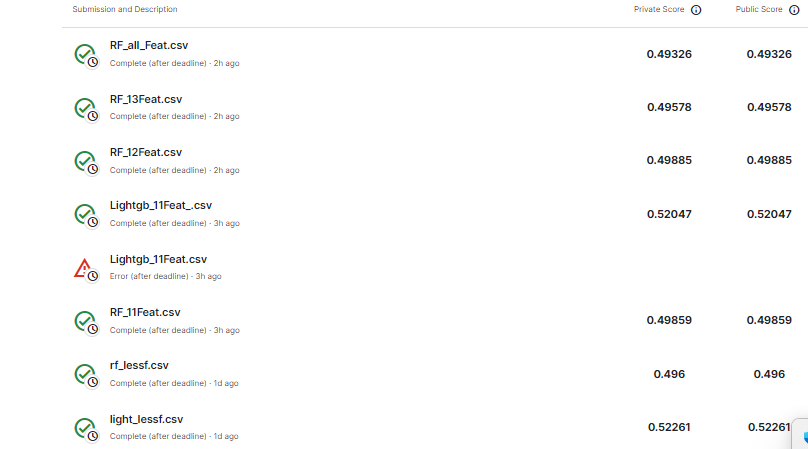

(array([0, 1, 2, 3, 4, 5]),
 [Text(0, 0, 'Random Forest'),
  Text(1, 0, 'LGBMRegressor'),
  Text(2, 0, 'CatBoostRegressor'),
  Text(3, 0, 'Decision Tree'),
  Text(4, 0, 'KNeighborsRegressor'),
  Text(5, 0, 'Ridge Regression')])

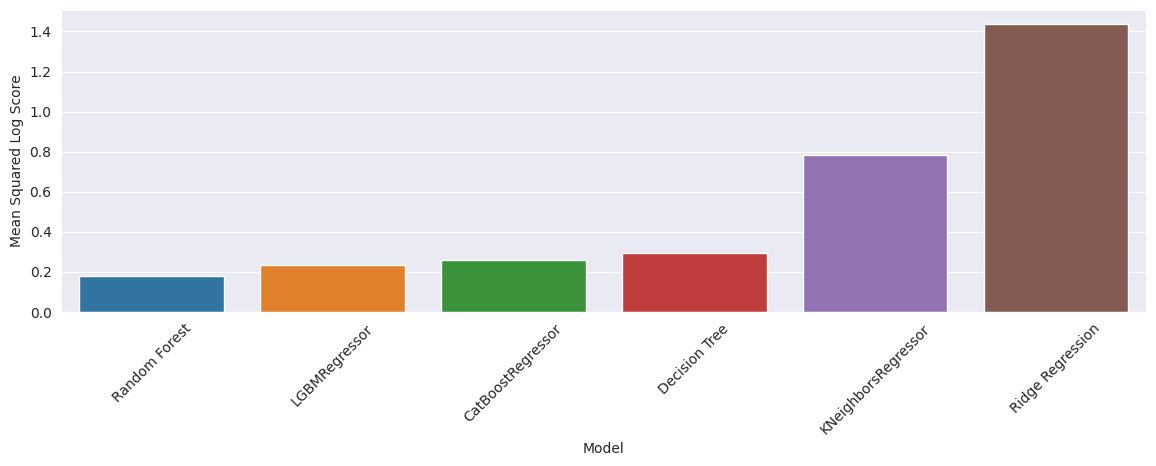

In [ ]:
plt.figure(figsize=(14,4),dpi=100)
sns.barplot(x='Model',y="Mean Squared Log Score",data=final_results.sort_values("Mean Squared Log Score"))
plt.xticks(rotation=45)

## Feature Importance

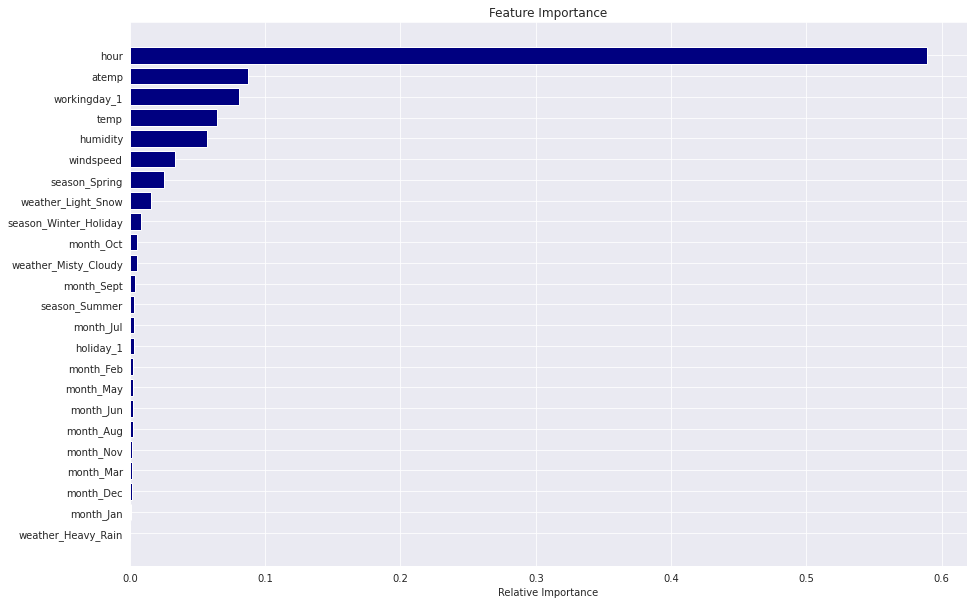

In [ ]:
features = final_df_features.columns
importances = regressor_RF.feature_importances_
indices = np.argsort(importances)
plt.figure(figsize=(15,10))
plt.title('Feature Importance')
plt.barh(range(len(indices)), importances[indices], color='navy', align='center')
plt.yticks(range(len(indices)), [features[i] for i in indices])
plt.xlabel('Relative Importance')
plt.show()
